# 1.IMPORT LIBRARIES

In [1]:
!pip install skrebate
!pip install scikit-optimize
!pip install xgboost
!pip install lightgbm
!pip install catboost

  Preparing metadata (setup.py) ... done
  Created wheel for skrebate: filename=skrebate-0.62-py3-none-any.whl size=29253 sha256=8d61b1ea884a8f684b94b2e453cd8083bdb3970482ca91dff237b146f847a875
  Stored in directory: /root/.cache/pip/wheels/03/4c/36/bc6b70d88998635e0ec0e617d15cd97483f5008d6bb77c1c7a
Successfully built skrebate
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.3 MB/s eta 0:00:00


In [75]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score
from skopt import BayesSearchCV
from skopt.space import Integer,Categorical,Real
from sklearn.metrics import roc_curve,auc
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from skrebate import ReliefF
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from google.colab import drive

In [3]:
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


# 2.READ DATA

In [4]:
X=pd.read_csv('/content/gdrive/MyDrive/demo_TCGA_BRCA/results/normalized_data_up_genes.csv',
              index_col=0)
X=X[~X.index.isnull()]
X=X.T
X.sort_index(inplace=True)

In [5]:
y=pd.read_csv('/content/gdrive/MyDrive/demo_TCGA_BRCA/Final data/temp_meta_data.csv',index_col=0)
y.sort_index(inplace=True)
y=(y['follow_ups_disease_response']=='WT-With Tumor').astype('int')

In [8]:
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.8,stratify=y,shuffle=True)

# 3.TRAIN AND TUNE MODEL

In [9]:
# model
xgb=XGBClassifier()
forest=RandomForestClassifier()
cat=CatBoostClassifier()
light=LGBMClassifier()
# number of fold
kfold=StratifiedKFold(n_splits=10,shuffle=True)

In [11]:
# Bayesian Opitimazation 'Support vector machine':[svm,{'C': Categorical([0.1, 1, 10, 100, 1000])}],
Dict={
    'XGBoost':[xgb,{'n_estimators': Integer(100, 500),
                    'learning_rate': Categorical([0.01, 0.05, 0.1]),
                    'max_depth': Integer(3,10),
                    'min_child_weight': Integer(2,15),
                    'gamma': Categorical([0, 0.1, 0.2]),
                    'subsample': Categorical([0.8, 1.0]),
                    'colsample_bytree': Categorical([0.8, 1.0])
}],
    'Random forest': [forest,{
        'n_estimators': Integer(10,200),
        'max_depth': Integer(1,20),
        'min_samples_split': Integer(2,10),
        'max_features': Real(0.1,1),
        'bootstrap': Categorical([True, False]),
        'criterion': Categorical(['gini','entropy']),
        'min_samples_leaf': Integer(1,4)
    }],
    'LightGBM': [light, {
        'n_estimators': Integer(200, 1000),
        'learning_rate': Categorical([0.01, 0.05, 0.1]),
        'num_leaves': Integer(7, 31),
        'max_depth': Integer(3, 7),
        'min_child_samples': Integer(5, 20),
        'colsample_bytree': Real(0.3, 0.7),
        'reg_alpha': Categorical([0, 0.1, 0.5, 1.0]),
        'reg_lambda': Categorical([0, 1.0, 3.0])
    }],
    'Cat Boost': [cat,{
        'iterations': Integer(200, 1000),
        'learning_rate': Categorical([0.01, 0.03, 0.05, 0.1]),
        'depth': Integer(3, 7),
        'l2_leaf_reg': Integer(1, 10),
        'random_strength': Real(1, 10),
        'subsample': Real(0.6, 1.0),
        'bootstrap_type': Categorical(['Bernoulli'])
    }]
}
models_tuning_result=[]
for k,v in Dict.items():
  print(f'Working on {k}....')
  # Define model
  estimator=v[0]
  # Define parameter grid
  para=v[1]
  # Parameter search
  search=BayesSearchCV(estimator=estimator,
                       cv=kfold,
                       random_state=42,
                       scoring='accuracy',
                       verbose=1,
                       search_spaces=para,
                       n_jobs=-1,
                       refit=True,
                       n_iter=3)
  # Train model
  search.fit(X_train,y_train)
  # Select the best model
  best_model=search.best_estimator_
  # Get result summary
  models_tuning_result.append({'Model Name':k,'Model':best_model})

Working on XGBoost....
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Working on Random forest....
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Working on LightGBM....
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[LightGBM] [Info] Number of positive: 93, number of negative: 643
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42351
[LightGBM] [Info] Number of data points in the train set: 736, number of used features: 199
[LightGBM] [Info] [b

In [13]:
# SAVE TUNNED MODEL DICTIONARY
with open('/content/gdrive/MyDrive/demo_TCGA_BRCA/results/tuned_model_dict.pkl','wb') as f:
  pkl.dump(models_tuning_result,f)
print('Complete!')

Complete!


# 4.SELECT IMPORTANT GENES

In [87]:
# LOAD TUNNED MODEL DICTIONARY
with open('/content/gdrive/MyDrive/demo_TCGA_BRCA/results/tuned_model_dict.pkl','rb') as f:
  models_tuning_result=pkl.load(f)
print('Complete!')

Complete!


In [88]:
dict_feature_importance={}
for model in models_tuning_result:
  dict_feature_importance[model.get('Model Name')]=model.get('Model').feature_importances_
df_feature_importance=pd.DataFrame(dict_feature_importance,index=X_train.columns)
df_feature_importance.to_csv('/content/gdrive/MyDrive/demo_TCGA_BRCA/results/feature_importance.csv')
df_feature_importance

,XGBoost,Random forest,LightGBM,Cat Boost
ABCB5,0.000000,0.002184,4,0.418336
CNTN1,0.000000,0.001150,3,0.481385
ABCC2,0.003565,0.008220,24,0.473303
KCNG1,0.000000,0.003258,8,0.616588
CREB3L3,0.008168,0.010201,29,0.277542
...,...,...,...,...
SYT15B,0.000000,0.015456,25,0.282032
LOC130932201,0.005591,0.003293,7,0.416393
LOC107984270,0.000000,0.002514,3,0.812795
LOC105376381,0.013945,0.004017,13,0.677039


In [89]:
model_evaluation_result=[]
for result in models_tuning_result:
  print(f'Working on {result.get('Model Name')}....')
  cross_train=cross_val_score(estimator=result.get('Model'),X=X_train,y=y_train,cv=kfold,n_jobs=-1,scoring='accuracy')
  cross_test=cross_val_score(estimator=result.get('Model'),X=X_test,y=y_test,cv=kfold,n_jobs=-1,scoring='accuracy')
  model_evaluation_result.append({
      'Model name': result.get('Model Name'),
      'Average accuracy train':cross_train.mean(),
      'STD accuracy train' : cross_train.std(),
      'Average accuracy test':cross_test.mean(),
      'STD accuracy test' : cross_test.std()
  })

Working on XGBoost....
Working on Random forest....
Working on LightGBM....
Working on Cat Boost....


In [90]:
df_model_evaluation_result=pd.DataFrame(model_evaluation_result)
df_model_evaluation_result

,Model name,Average accuracy train,STD accuracy train,Average accuracy test,STD accuracy test
0,XGBoost,0.873658,0.005798,0.876023,0.022314
1,Random forest,0.872288,0.006491,0.870760,0.033231
2,LightGBM,0.873658,0.010328,0.876023,0.022314
3,Cat Boost,0.873658,0.005798,0.876023,0.022314


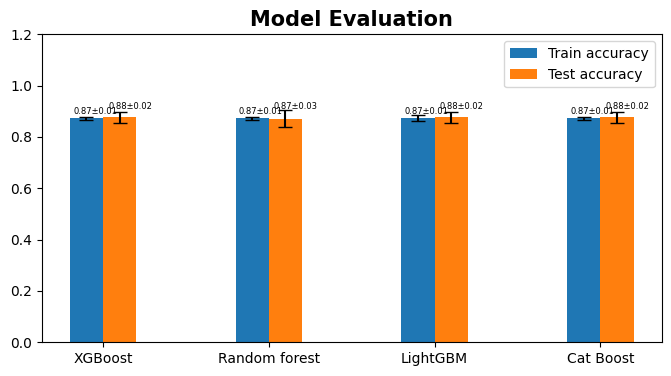

In [91]:
# MODEL EVALUATION VISUALIZATION
plt.figure(figsize=(8,4))
plt.title('Model Evaluation',size=15,weight=900)
x_index=df_model_evaluation_result.index
bar_width=0.2
plt.bar(x=x_index-bar_width/2,
        height=df_model_evaluation_result['Average accuracy train'],
        width=bar_width,
        label='Train accuracy')
plt.bar(x=x_index+bar_width/2,
        height=df_model_evaluation_result['Average accuracy test'],
        width=bar_width,
        label='Test accuracy')
plt.errorbar(x=x_index-bar_width/2,
             y=df_model_evaluation_result['Average accuracy train'],
             color='Black',
             ls='none',
             yerr=df_model_evaluation_result['STD accuracy train'],
             capsize=5)
plt.errorbar(x=x_index+bar_width/2,
             y=df_model_evaluation_result['Average accuracy test'],
             color='Black',
             ls='none',
             yerr=df_model_evaluation_result['STD accuracy test'],
             capsize=5
             )
for i in x_index:
  acc_train=round(df_model_evaluation_result.iloc[i,1],2)
  acc_test=round(df_model_evaluation_result.iloc[i,3],2)
  std_train=round(df_model_evaluation_result.iloc[i,2],2)
  std_test=round(df_model_evaluation_result.iloc[i,4],2)
  plt.text(x=i-bar_width+0.02,y=acc_train+std_train+0.01,s=f'{acc_train}±{std_train}',size=6)
  plt.text(x=i+bar_width-0.17,y=acc_test+std_test+0.01,s=f'{acc_test}±{std_test}',size=6)
plt.ylim([0,1.2])
plt.xticks(ticks=x_index,labels=df_model_evaluation_result['Model name'])
plt.legend()
plt.savefig('/content/gdrive/MyDrive/demo_TCGA_BRCA/results/model_evaluation.png')
plt.show()

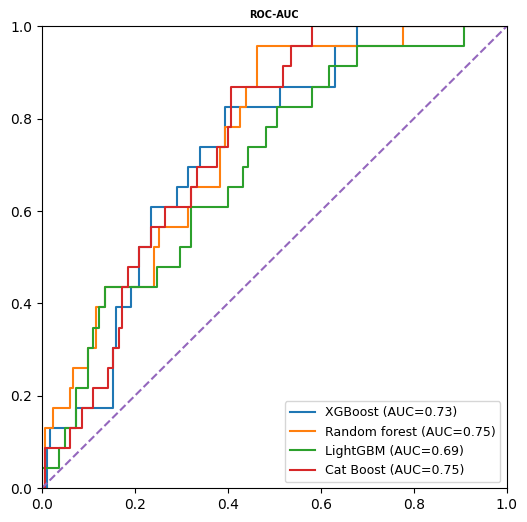

In [92]:
# ROC-AUC CURVE
plt.figure(figsize=(6,6))
plt.title('ROC-AUC',size=7,weight=800)
for result in models_tuning_result:
  y_prob=result.get('Model').predict_proba(X_test)[:,1]
  fpr,tpr,threshold=roc_curve(y_true=y_test,y_score=y_prob)
  auc_val=round(auc(fpr,tpr),2)
  model_name=result.get('Model Name')
  plt.plot(fpr,tpr,label=f'{model_name} (AUC={auc_val})')
  plt.xlim([0,1])
  plt.ylim([0,1])
plt.plot([0,1],[0,1],linestyle='--')
plt.legend(fontsize=9)
plt.savefig('/content/gdrive/MyDrive/demo_TCGA_BRCA/results/roc.png')
plt.show()



# 4.FEATURE SELECTION WITH MODEL COUPLED WITH RFE

In [ ]:
# model
forest=RandomForestClassifier(random_state=42)
pipeline=Pipeline(steps=[
      ['feature_selection',RFE(forest)],
      ['model',forest]
      ])
# Train model
search.fit(X_train,y_train)
# Select the best model
best_model=search.best_estimator_

In [ ]:
# Cross-validation
cross_valid_result=[]
for i in models_tuning_result:
  # Define model
  model_name=i.get('Model Name')
  model=i.get('Model')
  # Cross-validation
  cross_val=cross_val_score(estimator=model,X=X_train,y=y_train,cv=kfold,scoring='accuracy')
  result=f'{round(cross_val.mean(),4)}±{round(cross_val.std(),4)}'
  # Result Summary
  cross_valid_result.append({'Model':model_name,'Average Accuracy':result})

In [ ]:
cross_valid_result

[{'Model': 'Support vector machine', 'Average Accuracy': '0.0029±0.0086'},
 {'Model': 'Decision tree', 'Average Accuracy': '0.0113±0.0138'},
 {'Model': 'Random forest', 'Average Accuracy': '0.0084±0.0129'}]

# TEST

In [ ]:
tree= DecisionTreeClassifier(random_state=42)
para={'criterion':  Categorical(['gini', 'entropy']),
                           'max_depth': Integer(2,10),
                           'min_samples_split': Integer(2,10),
                           'min_samples_leaf': Integer(2,10),
                           'max_features': Categorical([None, 'sqrt', 'log2']),
                           'ccp_alpha': Categorical([0,0.01])}
kfold=KFold(n_splits=10,
            random_state=42,
            shuffle=True)
# Parameter search
search=BayesSearchCV(estimator=tree,
                       cv=kfold,
                       random_state=42,
                       scoring='accuracy',
                       verbose=1,
                       search_spaces=para,
                       n_jobs=-1,
                       refit=True,
                       n_iter=3)
# Train model
search.fit(X_train,y_train)
# Select the best model
best_model=search.best_estimator_

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


In [ ]:
result_feature_score=pd.DataFrame({'score of feature':best_model.feature_importances_},
                                  index=best_model.feature_names_in_)
result_feature_score.sort_values(by='score of feature',ascending=False,inplace=True)
list_importance_gene=result_feature_score.head(3).index
list_importance_gene

Index(['RGS9BP', 'DNTT', 'RIMBP2'], dtype='object')

In [ ]:
X=X.loc[:,list_importance_gene]
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.8,random_state=42)

In [ ]:
tree= DecisionTreeClassifier(random_state=42)
para={'criterion':  Categorical(['gini', 'entropy']),
                           'max_depth': Integer(2,10),
                           'min_samples_split': Integer(2,10),
                           'min_samples_leaf': Integer(2,10),
                           'max_features': Categorical([None, 'sqrt', 'log2']),
                           'ccp_alpha': Categorical([0,0.01])}
kfold=KFold(n_splits=10,
            random_state=42,
            shuffle=True)
# Parameter search
search=BayesSearchCV(estimator=tree,
                       cv=kfold,
                       random_state=42,
                       scoring='accuracy',
                       verbose=1,
                       search_spaces=para,
                       n_jobs=-1,
                       refit=True,
                       n_iter=20)
# Train model
search.fit(X_train,y_train)
# Select the best model
best_model=search.best_estimator_
# Cross validation
cross_val=cross_val_score(estimator=best_model,X=X_train,y=y_train,cv=kfold,scoring='accuracy')

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

In [76]:
temp_model=temp[0].get('Model')
list_import_genes=temp_model.feature_names_in_[np.argsort(temp_model.feature_importances_)[::-1]]
feature_importance_result=[]
for i in range(2,5):
  # Prepare data
  list_genes=list_import_genes[0:i]
  X_train_important_genes=X_train[list_genes]
  X_test_important_genes=X_test[list_genes]
  # Clone model
  temp_model_ver2=clone(temp_model)
  # Cross validation
  cross_train= cross_val_score(estimator=temp_model_ver2,X=X_train_important_genes,y=y_train,cv=kfold,n_jobs=-1,verbose=1,scoring='accuracy')
  cross_test= cross_val_score(estimator=temp_model_ver2,X=X_test_important_genes,y=y_test,cv=kfold,n_jobs=-1,verbose=1,scoring='accuracy')
  # Average accuracy
  av_acc_train=cross_train.mean()
  av_acc_test=cross_test.mean()
  feature_importance_result.append({'Accuracy train':av_acc_train,'Accuracy test': av_acc_test})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished


In [86]:
# Prepare data
list_genes=list_import_genes[0:100]
X_train_important_genes=X_train[list_genes]
X_test_important_genes=X_test[list_genes]
# Clone model
temp_model_ver2=clone(temp_model)
temp_model_ver2.fit(X_train_important_genes,y_train)
round(temp_model_ver2.score(X_train_important_genes,y_train),4), round(temp_model_ver2.score(X_test_important_genes,y_test),4)

(0.8736, 0.8757)

In [77]:
pd.DataFrame(feature_importance_result,index=range(2,5))

,Accuracy train,Accuracy test
2,0.873658,0.876023
3,0.873658,0.876023
4,0.873658,0.876023


In [59]:
pd.DataFrame({'gene':temp_model.feature_names_in_,'score':temp_model.feature_importances_}).sort_values('score',ascending=False).head(10)

,gene,score
68,FGF2,0.025254
93,SLC9C2,0.020781
159,CPEB1,0.019896
180,CFHR1,0.018918
177,VLDLR-AS1,0.018150
57,FIBCD1,0.017909
28,TSPAN12,0.017641
78,EPHA5,0.017128
19,PITPNM3,0.017056
181,LINC01331,0.016968


In [43]:
pd.DataFrame(feature_importance_result,index=range(2,5))

,Accuracy train,Accuracy test
2,0.873658,0.876023
3,0.873658,0.876023
4,0.873658,0.876023
